# Testing of OCDFG Streaming Discovery

This notebook demonstrates how to use the `OCOperator` for real-time object-centric process discovery.
The `OCOperator` is responsible for managing per-object-type miners, applying lossy counting for object filtering, and dynamically discovering object-object relations.

---

## OCOperator Overview

The `oc_operator()` factory accepts the following parameters:

### 1. `control_flow: Optional[Dict[str, Callable[[], StreamMiner]]]`
A dictionary mapping each object type to a callable producing a stream miner (e.g., Heuristics Miner).
If provided, the operator uses this to statically assign miners to object types.
If `None`, the operator enters **dynamic mode**, registering miners on-the-fly when new object types appear.

> **Note**: Each miner must conform to the `StreamMiner` protocol, consuming `BOEvent` streams and emitting models (e.g., HeuristicsNet).

---

### 2. `object_max_approx_error: float = 0.0001`
Controls lossy counting for object type frequency tracking.
Object types with too low frequency are periodically **deregistered** via control signals.

- Lower values = more precise tracking.
- Higher values = faster forgetting of rare object types.

---

### 3. `relation_model_update_frequency: int = 30`
Defines how often the AER (Activity-Entity Relationship) model is updated.
After every *N* `BOEvent`s, the AER miner emits a new diagram capturing:

- Unary participation (single object type per activity)
- Binary relations (pairwise co-occurrence of object types with cardinality)

---

### 4. `relation_max_approx_error: float = 0.01`
Controls the lossy counting precision for AER relation discovery.
This applies forgetting to low-frequency object-object combinations to retain only stable, recurring structures.

---

## Architecture Summary

The `OCOperator` internally manages:

- **DFG Streams**: One per object type (`Order`, `Item`, etc.), each with its own miner.
- **AER Stream**: A dedicated stream for discovering relationships between object types across activities.
- **Dynamic Registration**: In absence of a `control_flow`, object types are dynamically registered with default miners.
- **Stream Routing**: Flattened `BOEvent`s are routed to their respective object-type streams, while the full event is used for AER analysis.

---

## Output

The operator emits dictionaries of the form:

```python
{
  "type": "model" | "aer_diagram" | "command",
  "object_type": str,       # only for "model" and "command"
  "model": HeuristicsNet or ActivityERDiagram,
  "command": Command.DEREGISTER  # if applicable
}


# OCOperator in Action

The following scripts will showcase some of the features of the OCOperator

In [1]:
# Imports
from pybeamline.algorithms.oc.oc_merge_operator import oc_merge_operator
import importlib
import pybeamline
from pybeamline.algorithms.oc.oc_operator import oc_operator, MiningStrategy
from pybeamline.algorithms.oc.strategies.base import LossyCountingStrategy

importlib.reload(pybeamline)
from typing import Tuple, List, Any, Dict
from pybeamline.objects.ocdfg import OCDFG
from pybeamline.sources.ocel_log_source_from_file import ocel_log_source_from_file
from pm4py.algo.discovery.ocel.ocdfg import algorithm as ocdfg_discovery
from pm4py.read import read_ocel2_json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pybeamline.sources.dict_ocel_test_source import dict_test_ocel_source

In [2]:
# Build a source from dict
dict_source = [
        {"activity": "Register Customer", "objects": {"Customer": ["c1"]}},
        {"activity": "Create Order", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
        {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i1"]}},
        {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i2"]}},
        {"activity": "Reserve Item", "objects": {"Item": ["i1"]}},
        {"activity": "Pack Item", "objects": {"Item": ["i1","i2"], "Order": ["o1"]}},
        {"activity": "Ship Item", "objects": {"Item": ["i1","i2"], "Shipment": ["s1"]}},
        {"activity": "Send Invoice", "objects": {"Order": ["o1"], "Invoice": ["inv1"]}},
        {"activity": "Receive Review", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
        ]

source = dict_test_ocel_source([(dict_source,10)])

source.pipe(
).subscribe(print)


{'ocel:eid': 'e0', 'ocel:activity': 'Register Customer', 'ocel:timestamp': datetime.datetime(2025, 6, 8, 23, 24, 34, 783233), 'ocel:omap': {'Customer': {'c1_0'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e1', 'ocel:activity': 'Create Order', 'ocel:timestamp': datetime.datetime(2025, 6, 8, 23, 24, 34, 783233), 'ocel:omap': {'Customer': {'c1_0'}, 'Order': {'o1_0'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e2', 'ocel:activity': 'Add Item', 'ocel:timestamp': datetime.datetime(2025, 6, 8, 23, 24, 34, 784235), 'ocel:omap': {'Order': {'o1_0'}, 'Item': {'i1_0'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e3', 'ocel:activity': 'Add Item', 'ocel:timestamp': datetime.datetime(2025, 6, 8, 23, 24, 34, 784235), 'ocel:omap': {'Order': {'o1_0'}, 'Item': {'i2_0'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e4', 'ocel:activity': 'Reserve Item', 'ocel:timestamp': datetime.datetime(2025, 6, 8, 23, 24, 34, 784235), 'ocel:omap': {'Item': {'i1_0'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e5', 'ocel:activity': 'Pack Item', 'ocel:timestamp': datetime.datetim

## Default initialisation

As shown earlier the *default* behavior of `oc_operator` is based on dynamic discovery, in which all Object-Type Stream Miners are set to `heuristics_lossy_counting(10)`, and

In [3]:
# Imports
from pybeamline.algorithms.oc.oc_merge_operator import oc_merge_operator
import importlib
import pybeamline
from pybeamline.algorithms.oc.oc_operator import oc_operator
importlib.reload(pybeamline)
from typing import Tuple, List, Any, Dict
from pybeamline.objects.ocdfg import OCDFG
from pybeamline.sources.ocel_log_source_from_file import ocel_log_source_from_file
from pm4py.algo.discovery.ocel.ocdfg import algorithm as ocdfg_discovery
from pybeamline.algorithms.oc.strategies.base import RelativeFrequencyBasedStrategy
from pm4py import read_ocel2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [4]:

# Helper functions
# Path to the OCEL2 log file
log_path = '../../tests/logistics.jsonocel'

# PM4Py
def read_ocel2_log(filename: str):
    return read_ocel2(filename)

# Load the OCEL log
oc_event_log = read_ocel2_log(log_path)


# Do OCDFG static discovery
ocdfg = ocdfg_discovery.apply(oc_event_log)
def conform_ocdfg(ocdfg_pm4py) -> set[Tuple[str, str, str]]:
    """
    Convert PM4Py OCDFG to a set of edges in the format (source, object_type, target).
    """
    result = set()
    for obj_type in ocdfg_pm4py["edges"]["event_couples"].keys():
        for src, tgt in ocdfg_pm4py["edges"]["event_couples"][obj_type].keys():
            result.add((src, obj_type, tgt))
    return result
# Convert the PM4Py OCDFG to a set of edges
ocdfg_edges_pm4py = conform_ocdfg(ocdfg)


# Create source from file
source = ocel_log_source_from_file(log_path)

# Set based jaccard similarity function
def jaccard_similarity(model: set, ref_model: set) -> float:
    intersection = model.intersection(ref_model)
    #if intersection is not None:
    #    print(f"The missing edges in the model: {ref_model - intersection}")
    intersection = len(model.intersection(ref_model))
    union = len(model.union(ref_model))

    if union == 0:
        return 0.0
    return intersection / union

# Conform the emitted OCDFGs to the set notation of edges
def conform_emit_ocdfg(ocdfg: OCDFG) -> set[tuple[str, str, str]]:
    """
    Convert OCDFG to a set of edges in the format (source, object_type, target).
    """
    result = set()
    for obj_type, transitions in ocdfg.edges.items():
        for (src, tgt), freq in transitions.items():
            result.add((src, obj_type, tgt))
    return result



emitted_ocdfgs = []
def append_ocdfg(output):
    global emitted_ocdfgs
    emitted_ocdfgs.append(output["ocdfg"])


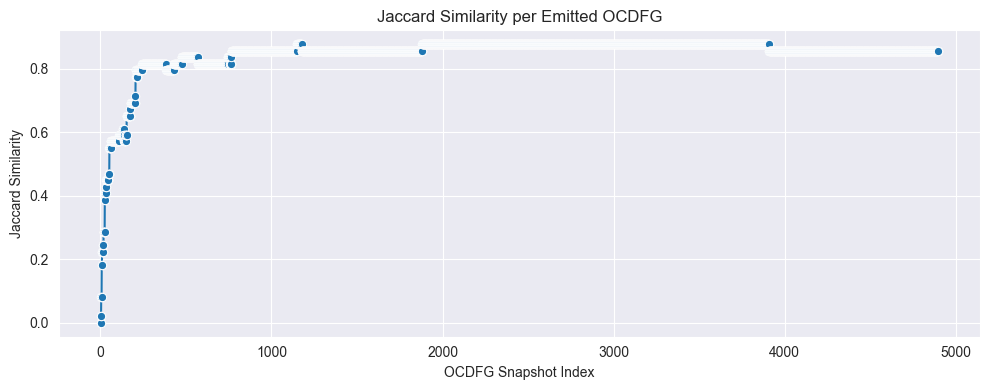

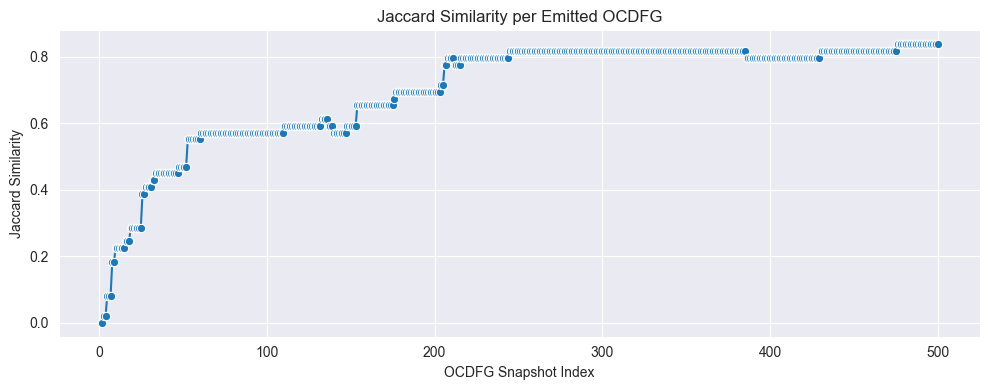

In [5]:


# Streaming of Object-Centric Process Mining

source.pipe(
    oc_operator(strategy_handler=RelativeFrequencyBasedStrategy(frequency_threshold=0.0001)),
    oc_merge_operator()
).subscribe(append_ocdfg)

# Conform to set-based ocdfg
emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

jacc_similarities = []
for ocdfg_edge_set in emitted_ocdfgs_edge_set:
    similarity = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_pm4py)
    jacc_similarities.append(similarity)


# Create a DataFrame for Seaborn
df = pd.DataFrame({
    "Snapshot": range(1, len(jacc_similarities) + 1),
    "Jaccard Similarity": jacc_similarities
})

# Plot
plt.figure(figsize=(10, 4))
sns.lineplot(data=df, x="Snapshot", y="Jaccard Similarity", marker="o")
plt.title("Jaccard Similarity per Emitted OCDFG")
plt.xlabel("OCDFG Snapshot Index")
plt.ylabel("Jaccard Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()

jacc_sim_slice = jacc_similarities[:500]  # Display the first 500 similarities for brevity
df_slice = pd.DataFrame({
    "Snapshot": range(1, len(jacc_sim_slice) + 1),
    "Jaccard Similarity": jacc_sim_slice
})

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_slice, x="Snapshot", y="Jaccard Similarity", marker="o")
plt.title("Jaccard Similarity per Emitted OCDFG")
plt.xlabel("OCDFG Snapshot Index")
plt.ylabel("Jaccard Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()


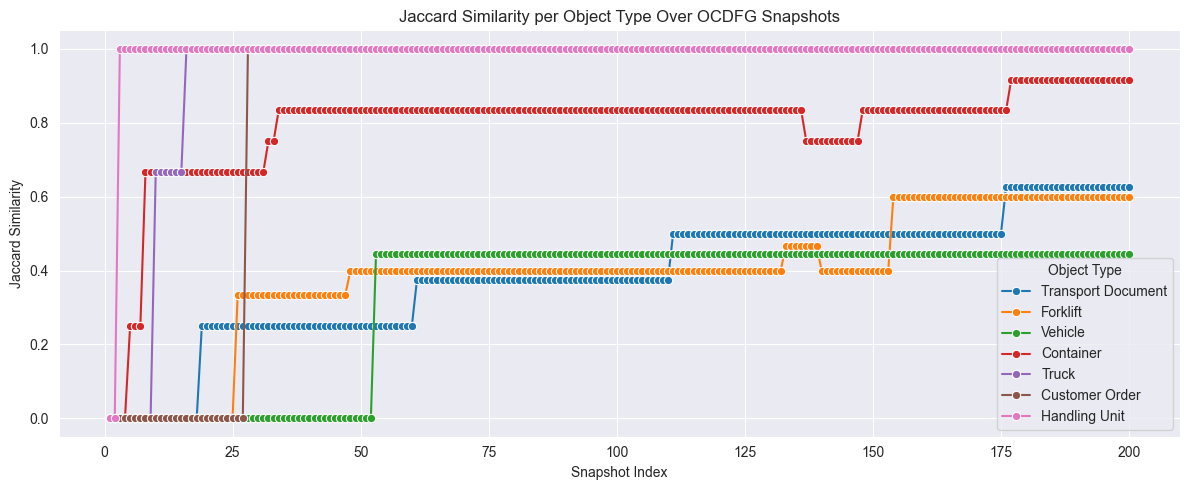

In [6]:

def egdes_pr_object_type(ocdfg: set[Tuple[str,str,str]]) -> Dict[str, set[Tuple[str, str, str]]]:
    """
    Convert OCDFG to a dictionary of edges per object type.
    """
    result = {}
    for src, obj_type, tgt in ocdfg:
        if obj_type not in result:
            result[obj_type] = set()
        result[obj_type].add((src,obj_type, tgt))
    return result

# Convert the PM4Py OCDFG edges to a dictionary of edges per object type
ocdfg_edges_per_object_type = egdes_pr_object_type(ocdfg_edges_pm4py)

emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

obj_type_jacc_similarities = {}

for snapshot in emitted_ocdfgs_edge_set:
    snapshot_per_obj = egdes_pr_object_type(snapshot)

    for obj_type, ref_edges in ocdfg_edges_per_object_type.items():
        # Initialize list if first time
        if obj_type not in obj_type_jacc_similarities:
            obj_type_jacc_similarities[obj_type] = []

        model_edges = snapshot_per_obj.get(obj_type, set())
        similarity = jaccard_similarity(model_edges, ref_edges)
        obj_type_jacc_similarities[obj_type].append(similarity)

records = []

for obj_type, similarities in obj_type_jacc_similarities.items():
    for i, sim in enumerate(similarities[:200], start=1):
        records.append({
            "Snapshot": i,
            "Object Type": obj_type,
            "Jaccard Similarity": sim
        })

df_long = pd.DataFrame(records)

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_long, x="Snapshot", y="Jaccard Similarity", hue="Object Type", marker="o")
plt.title("Jaccard Similarity per Object Type Over OCDFG Snapshots")
plt.xlabel("Snapshot Index")
plt.ylabel("Jaccard Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()



# Concept Drift

The following script demonstrates how the OCOperator can handle concept drift by dynamically registering new object types and miners.


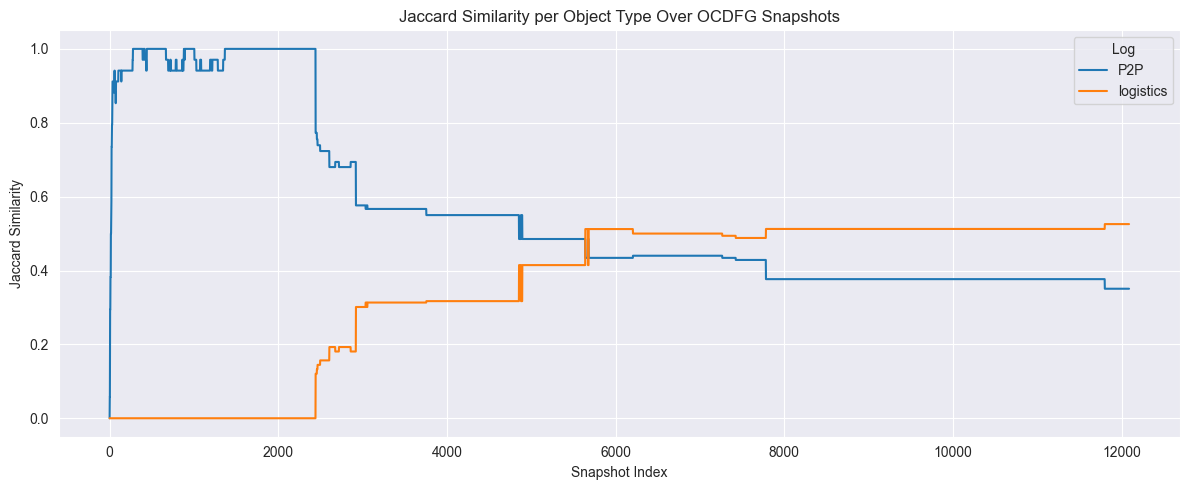

In [12]:
log_path2 = '../../tests/ocel2-p2p.json'
source = ocel_log_source_from_file(log_path)
source2 = ocel_log_source_from_file(log_path2)

# Process new log
# Load the OCEL log
# Do OCDFG static
oc_event_log = read_ocel2_log(log_path2)
ocdfg_p2p = ocdfg_discovery.apply(oc_event_log)
ocdfg_edges_p2p_pm4py = conform_ocdfg(ocdfg_p2p)


# Concatenate the two sources
from reactivex import concat
from reactivex import operators as ops
new_source = concat(source2,source)
new_source = concat(new_source, source)


emitted_ocdfgs = []
new_source.pipe(
    oc_operator(strategy_handler=RelativeFrequencyBasedStrategy(frequency_threshold=0.02)),
    oc_merge_operator()
).subscribe(lambda x: emitted_ocdfgs.append(x["ocdfg"]))

# Conform to set-based ocdfg
emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

jacc_similarities = []
for i, ocdfg_edge_set in enumerate(emitted_ocdfgs_edge_set, start=1):
    similarity_p2p = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_p2p_pm4py)
    similarity_logistics = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_pm4py)
    jacc_similarities.append({
        "snapshot": len(jacc_similarities) + 1,
        "p2p": similarity_p2p,
        "logistics": similarity_logistics
    })


df_long = pd.DataFrame([
    {"Snapshot": sim["snapshot"], "Log": "P2P", "Jaccard Similarity": sim["p2p"]}
    for sim in jacc_similarities
] + [
    {"Snapshot": sim["snapshot"], "Log": "logistics", "Jaccard Similarity": sim["logistics"]}
    for sim in jacc_similarities
])


plt.figure(figsize=(12, 5))
sns.lineplot(data=df_long, x="Snapshot", y="Jaccard Similarity", hue="Log")
plt.title("Jaccard Similarity per Log Over OCDFG Snapshots")
plt.xlabel("Snapshot Index")
plt.ylabel("Jaccard Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()


## Concept drift with Lossy Counting

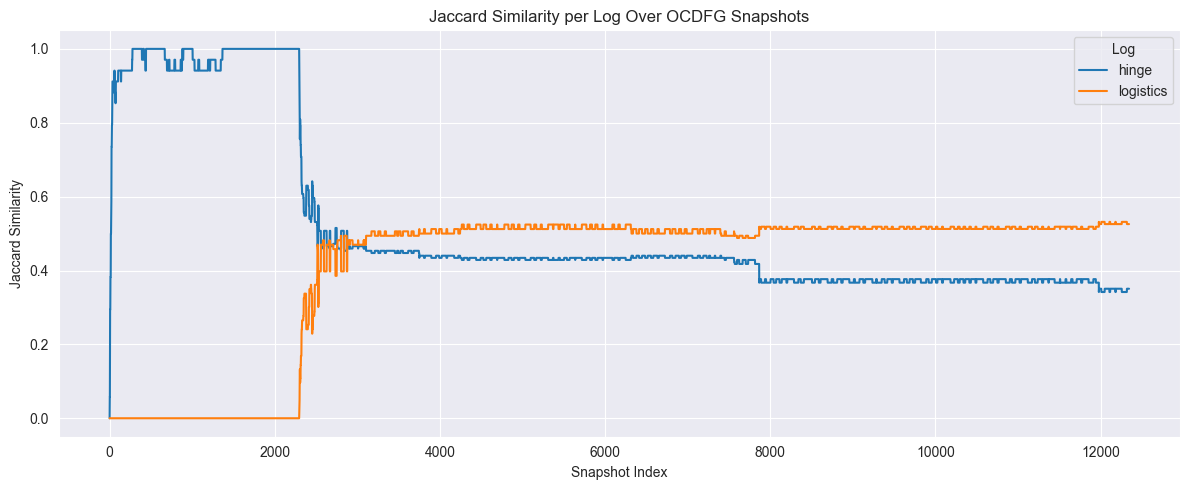

In [13]:
emitted_ocdfgs = []
new_source.pipe(
    oc_operator(strategy_handler=LossyCountingStrategy(max_approx_error=0.02)),
    oc_merge_operator()
).subscribe(lambda x: emitted_ocdfgs.append(x["ocdfg"]))

# Conform to set-based ocdfg
emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

jacc_similarities = []
for i, ocdfg_edge_set in enumerate(emitted_ocdfgs_edge_set, start=1):
    similarity_hinge = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_p2p_pm4py)
    similarity_logistics = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_pm4py)
    jacc_similarities.append({
        "snapshot": len(jacc_similarities) + 1,
        "hinge": similarity_hinge,
        "logistics": similarity_logistics
    })


df_long = pd.DataFrame([
    {"Snapshot": sim["snapshot"], "Log": "hinge", "Jaccard Similarity": sim["hinge"]}
    for sim in jacc_similarities
] + [
    {"Snapshot": sim["snapshot"], "Log": "logistics", "Jaccard Similarity": sim["logistics"]}
    for sim in jacc_similarities
])


plt.figure(figsize=(12, 5))
sns.lineplot(data=df_long, x="Snapshot", y="Jaccard Similarity", hue="Log")
plt.title("Jaccard Similarity per Log Over OCDFG Snapshots")
plt.xlabel("Snapshot Index")
plt.ylabel("Jaccard Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()